In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.stats import truncnorm

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

### Base Growth Model

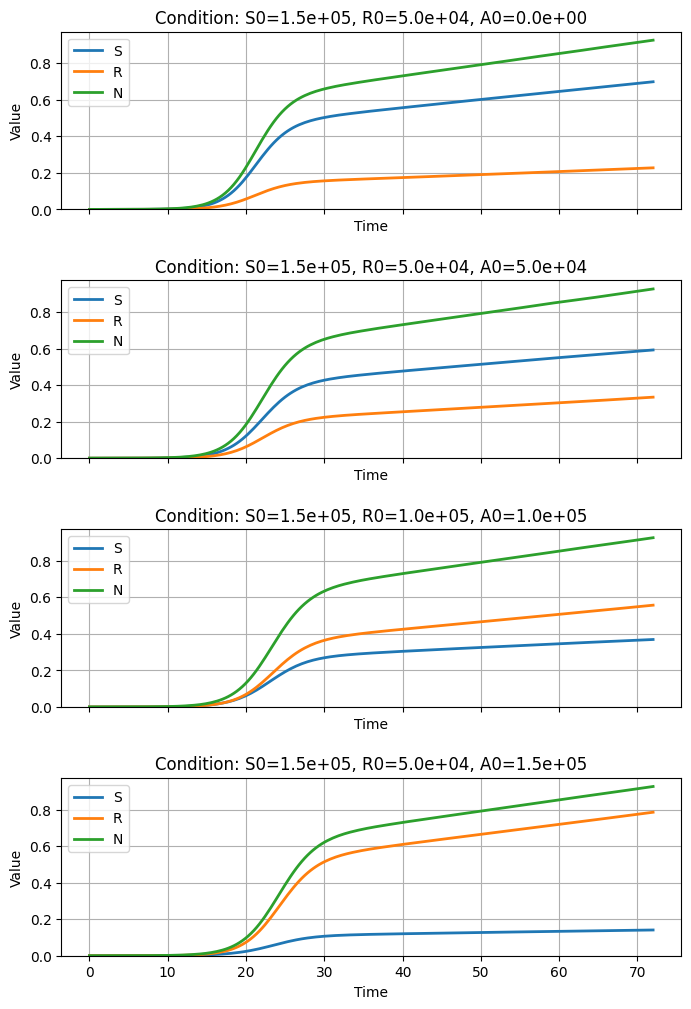

In [4]:
# model class
class GrowthModel:
    def __init__(self, p, vol_concent):
        self.p = p  # parameters
        self.vol_concent = vol_concent

    def __call__(self, t, y):
        y = np.maximum(y, 0) 
        S, R, N = y # diff eq functions
        
        # unpack parameters
        r, beta, lambda_, nu, rho, alpha, theta, E_max, MIC_S, MIC_R, mu, gamma = self.p
        V_i, A_i = self.vol_concent

        # model functions
        N = S + R # total bacteria population
        V = V_i + lambda_*t # slurry tank volume
        A = (A_i - (theta / gamma)) * np.exp(-1.0 * gamma * t) + (theta / gamma) # antibiotic concentration
        N_max =  mu * V # max carrying capacity
        H = 2 # Hill coefficient
        E_S = 1 - (E_max * (A / V)**H ) / (MIC_S**H + (A / V)**H) # antibiotic effect on sensitive
        E_R = 1 - (E_max * (A / V)**H) / (MIC_R**H + (A / V)**H) # antibiotic effect on resistant

        # differential equations
        dSdt = r * (1 - N/N_max) * E_S * S - (beta * S * R) / N + lambda_ * (1 - rho) * nu
        dRdt = r * (1 - alpha) * (1 - N/N_max) * E_R * R + (beta * S * R)/N + lambda_ * rho * nu
        dNdt = dSdt + dRdt

        return [dSdt, dRdt, dNdt]


# simulation class
class Simulation:
    def __init__(self, p, S0, R0, N0, V0, A0):
        self.p = p  # parameters
        self.S0 = S0  # inital sentitive pop
        self.R0 = R0  # initial resistant pop
        self.N0 = S0 + R0 # total pop

        self.V0 = V0  # initial volume in slurry tank
        self.A0 = A0  # initial antibiotic concentration

        self.y0 = np.array([S0, R0, N0])  # initial bacteria state
        self.vol_concent0 = np.array([V0, A0]) # initial env state

    def run(self, t_span=np.linspace(0, 24), num_time_points=500):
        t_eval = np.linspace(t_span[0], t_span[1], num_time_points)
        model = GrowthModel(self.p, self.vol_concent0)
        sol = solve_ivp(model, t_span, self.y0, t_eval=t_eval)
        return sol.t, sol.y*1e-15
    
# plotter class
class Plotter:
    def plot(self, t, results, conditions, variables=['S', 'R', 'N']):
        fig, axs = plt.subplots(4, 1, figsize=(8, 12), sharex=True)
        plt.subplots_adjust(hspace=0.4)

        # loop through the results for each condition and plot
        for i, (result, (S0, R0, V0, A0)) in enumerate(zip(results, conditions)):
            ax = axs[i]
            ax.set_title(f'Condition: S0={"{:.1e}".format(S0)}, R0={"{:.1e}".format(R0)}, A0={"{:.1e}".format(A0)}')
            for j, variable in enumerate(variables):
                ax.plot(t, result[j], label=variable, lw=2)

            ax.set_xlabel('Time')
            ax.set_ylabel('Value')
            ax.set_ylim(bottom=0)
            ax.grid(True)
            ax.legend()

        plt.show()



# parameters
p = [0.5, 0.001, 613, 2e7, 0.4, 0.1, 3422, 2, 8, 2000, 1e10, 0.0029]
t_span = (0, 72)
num_time_points = 200

# initial conditions
conditions = [(1.5e5, 0.5e5, 5e4, 0), (1.5e5, 0.5e5, 5e4, 0.5e5), (1.5e5, 1e5, 5e4, 1e5), (1.5e5, 0.5e5, 5e4, 1.5e5)]

# run simulation
all_results = []
for S0, R0, V0, A0 in conditions:
    N0 = S0 + R0
    sim = Simulation(p, S0, R0, N0, V0, A0)
    t, results = sim.run(t_span=t_span, num_time_points=num_time_points)
    all_results.append(results)

# plot results
plotter = Plotter()
plotter.plot(t, all_results, conditions)

### Sampling for Parameters

Simulations completed: 200/2000
Simulations completed: 400/2000
Simulations completed: 600/2000
Simulations completed: 800/2000
Simulations completed: 1000/2000
Simulations completed: 1200/2000
Simulations completed: 1400/2000
Simulations completed: 1600/2000
Simulations completed: 1800/2000
Simulations completed: 2000/2000


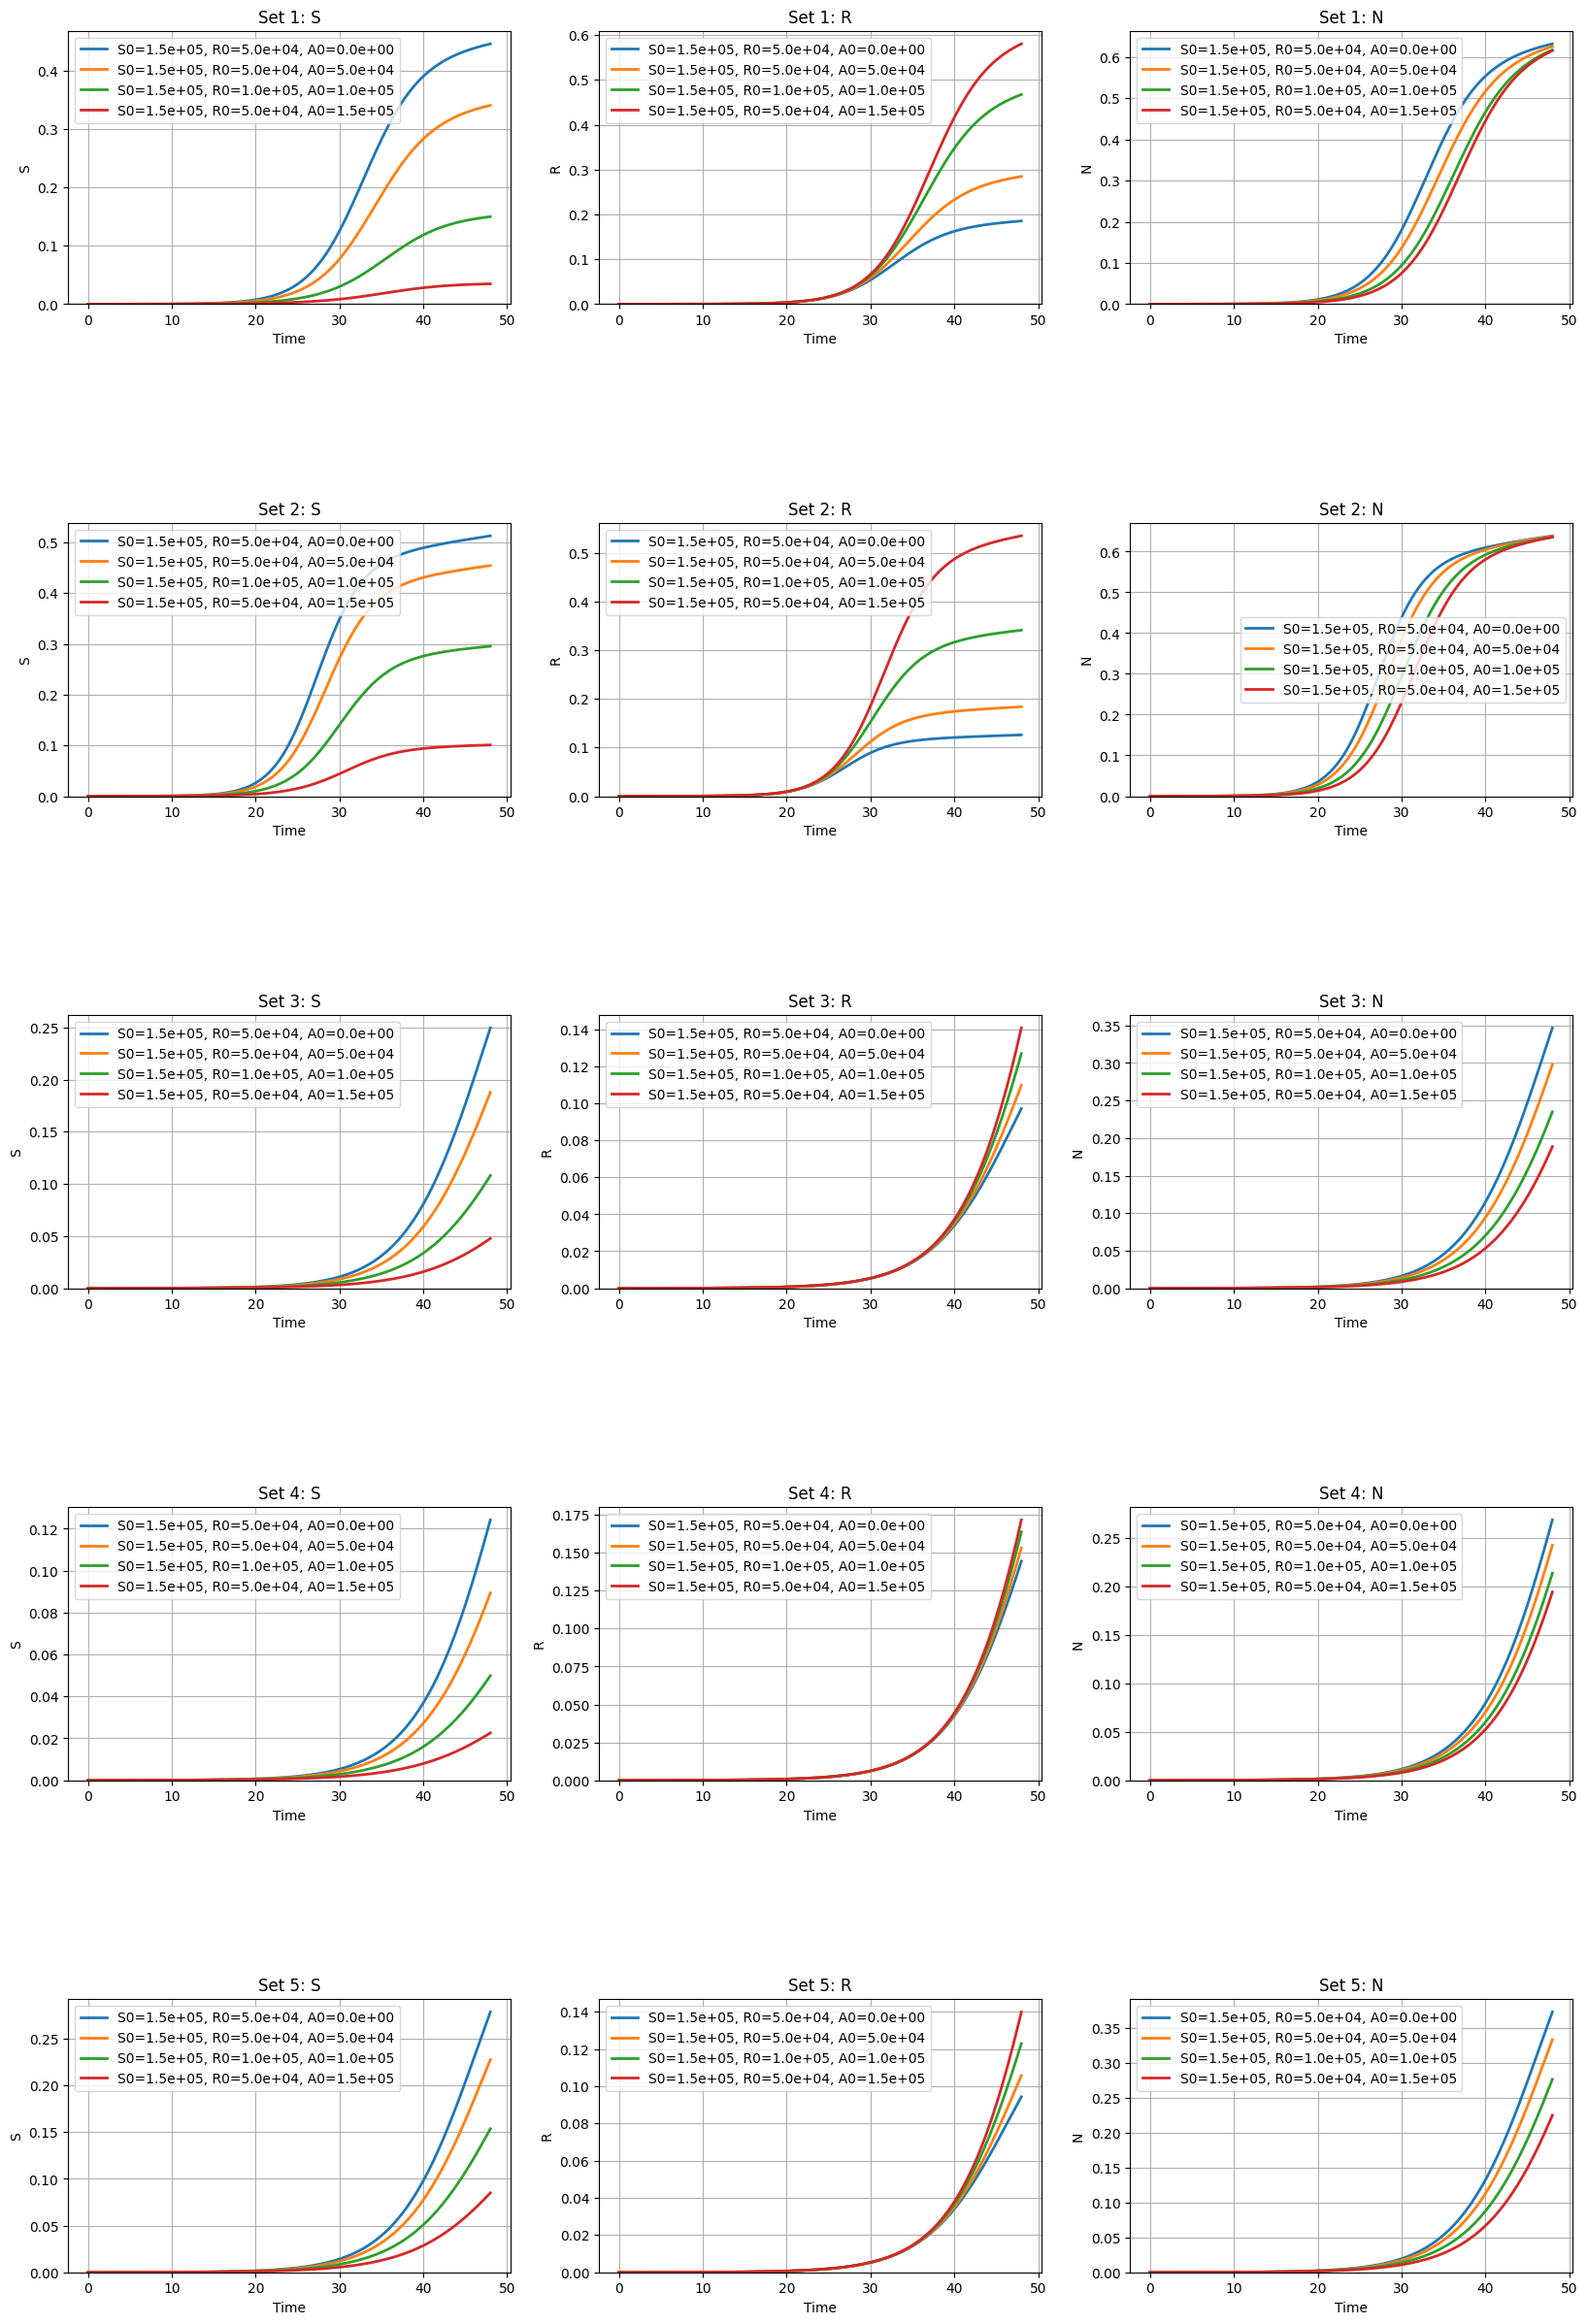

In [5]:
# sample from a truncated normal distribution
def sample_truncated_normal(mean, sd, low, upp, size=None):
    if sd == 0: return mean
    else:
        a, b = (low - mean) / sd, (upp - mean) / sd
        return truncnorm.rvs(a, b, loc=mean, scale=sd, size=size)

# parameter sampling class
class ParameterSampler:
    def __init__(self, param_specs, seed=None):
        self.param_specs = param_specs
        if seed is not None:
            np.random.seed(seed)

    def sample_parameters(self):
        p = []
        for key in ['r', 'beta', 'lambda_', 'nu', 'rho', 'alpha', 'theta', 'E_max', 'MIC_S', 'MIC_R', 'mu', 'gamma']:
            spec = self.param_specs[key]
            value = sample_truncated_normal(spec['mean'], spec['sd'], spec['low'], spec['high'])
            p.append(value)
        return p

# simulation class with sampling
class SimulationRunner:
    def __init__(self, num_simulations, conditions, t_eval, param_specs, seed=None):
        self.num_simulations = num_simulations
        self.conditions = conditions
        self.t_eval = t_eval
        self.param_sampler = ParameterSampler(param_specs, seed=seed)
        self.parameters = np.zeros((num_simulations, 12))
        self.curves = np.zeros((num_simulations, len(conditions), 3, len(t_eval)))

    def simulate(self, p, S0, R0, V0, A0):
        N0 = S0 + R0
        sim = Simulation(p, S0, R0, N0, V0, A0)
        _, results = sim.run(t_span=(0, 24), num_time_points=len(self.t_eval))
        return results

    def run_all_simulations(self):
        for i in range(self.num_simulations):

            # sample parameters for run
            p = self.param_sampler.sample_parameters()
            self.parameters[i] = p

            # run simulations under the specified conditions
            for j, (S0, R0, V0, A0) in enumerate(self.conditions):
                simulated = self.simulate(p, S0, R0, V0, A0)
                self.curves[i, j] = simulated

            if (i + 1) % 200 == 0:
                print(f'Simulations completed: {i + 1}/{self.num_simulations}')

        # save results to files
        np.savez_compressed('simulated_data/curves1k.npz', curves=self.curves, t_eval=self.t_eval)
        np.save('simulated_data/parameters.npy', self.parameters)

    def plot_results(self, num_sets_to_plot=10):
        variables = ['S', 'R', 'N']
        fig, axs = plt.subplots(num_sets_to_plot, 3, figsize=(20, 30))
        plt.subplots_adjust(hspace=0.8)

        for i in range(num_sets_to_plot):
            for j in range(3):
                ax = axs[i, j]
                variable = variables[j]

                for k, (S0, R0, V0, A0) in enumerate(self.conditions):
                    label = f'S0={"{:.1e}".format(S0)}, R0={"{:.1e}".format(R0)}, A0={"{:.1e}".format(A0)}'
                    ax.plot(self.t_eval, self.curves[i, k, j], label=label, lw=2)

                ax.set_ylim(bottom=0)
                ax.set_xlabel('Time')
                ax.set_ylabel(f'{variable}')
                ax.set_title(f'Set {i+1}: {variable}')
                ax.grid(True)
                ax.legend()

        plt.show()


# simulation parameters with sampling
param_specs = {
    'r': {'mean': 0.5, 'sd': 0.2, 'low': 0.17, 'high': 0.9},
    'beta': {'mean': 0.001, 'sd': 0.0005, 'low': 1e-9, 'high': 1e-2},
    'lambda_': {'mean': 613, 'sd': 25, 'low': 573, 'high': 653},
    'nu': {'mean': 2e7, 'sd': 5e6, 'low': 1.5e7, 'high': 2.5e7},
    'rho': {'mean': 0.4, 'sd': 0.2,  'low': 0.1, 'high': 0.7},
    'alpha': {'mean': 0.1, 'sd': 0.05,  'low': 0, 'high': 0.3},
    'theta': {'mean': 3422, 'sd': 50, 'low': 3322, 'high': 3522},
    'E_max': {'mean': 2, 'sd': 0.5, 'low': 1.5, 'high': 2.5},
    'MIC_S': {'mean': 8, 'sd': 1.5, 'low': 6.5, 'high': 9.5},
    'MIC_R': {'mean': 2000, 'sd': 250, 'low': 1750, 'high': 2250},
    'mu': {'mean': 1e10, 'sd': 0, 'low': 1e10, 'high': 1e10}, 
    'gamma': {'mean': 0.0029, 'sd': 0.002, 'low': 0.0005, 'high': 0.005}
}

# run simulation
num_simulations = 2000
conditions = [(1.5e5, 0.5e5, 5e4, 0), (1.5e5, 0.5e5, 5e4, 0.5e5), (1.5e5, 1e5, 5e4, 1e5), (1.5e5, 0.5e5, 5e4, 1.5e5)]
t_eval = np.linspace(0, 48, 150)
seed = 10

simulation_runner = SimulationRunner(num_simulations, conditions, t_eval, param_specs, seed=seed)
simulation_runner.run_all_simulations()

# plot results
simulation_runner.plot_results(num_sets_to_plot=5)


### Plotting Curves

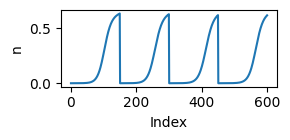

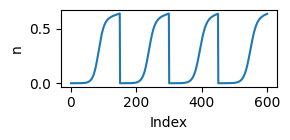

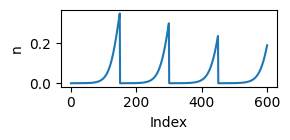

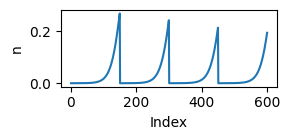

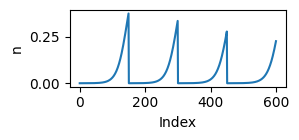

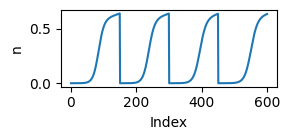

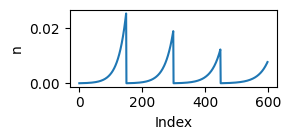

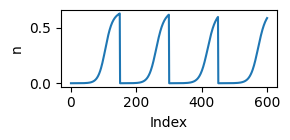

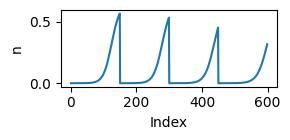

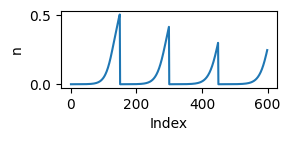

(2000, 600)


In [6]:
data_array = np.load('simulated_data\\curves1k.npz')['curves']

# conditions
conditions = [(1.5e5, 0.5e5, 5e4, 0), (1.5e5, 0.5e5, 5e4, 0.5e5), (1.5e5, 1e5, 5e4, 1e5), (1.5e5, 0.5e5, 5e4, 1.5e5)]
num_strains_to_display = 10

# store all concatenated S+R values
all_n_values = np.empty((data_array.shape[0], (data_array.shape[1])*(data_array.shape[3])))

# tterate over all strains
for strain_index in range(data_array.shape[0]):
    # extract and concatenate the S+R values for all conditions
    all_n_values[strain_index, :] = np.concatenate([data_array[strain_index, condition_index, 2, :] for condition_index in range(data_array.shape[1])])

    # if this is one of the top strains, create a figure and plot the curves
    if strain_index < num_strains_to_display:
        fig, ax = plt.subplots(figsize=(3, 1.5))

        # Plot the concatenated 'n' curve in this figure
        ax.plot(all_n_values[strain_index, :])

        # Set title of this figure to the current strain
        ax.set_xlabel('Index')
        ax.set_ylabel('n')

        # Show the figure
        plt.tight_layout()
        plt.show()

print(all_n_values.shape)